<a href="https://colab.research.google.com/github/google/jax-md/blob/notebook/notebooks/nvt_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports & Utils

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-releases/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-$(pip search jaxlib | grep -oP '[0-9\.]+' | head -n 1)-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax
!pip install -q git+https://www.github.com/google/jax-md

     |████████████████████████████████| 47.4MB 1.2MB/s 
     |████████████████████████████████| 215kB 2.9MB/s 
     |████████████████████████████████| 61kB 26.9MB/s 


In [0]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Temperature Simulation

Here we demonstrate some code to run a simulation at in the NVT ensemble. We start off by setting up some parameters of the simulation. This will include a temperature schedule that will start off at a high temperature and then instantaneously quench to a lower temperature.

In [0]:
N = 5000
dimension = 2
box_size = 80.0
dt = 1e-3
displacement, shift = space.periodic(box_size) 

T_schedule = lambda t: np.where(t < 1000.0 * dt, 1.0, 0.4)

Next we need to generate some random positions as well as particle sizes.

In [0]:
key = random.PRNGKey(0)

In [0]:
key, split = random.split(key)
R = random.uniform(
    split, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our simulation operators.

In [0]:
energy_fn = jit(energy.soft_sphere_pair(
    displacement, species=species, sigma=sigma, epsilon=10.0))

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, T_schedule)
apply = jit(apply)
state = init(key, R)

Now let's actually do the simulation. We'll keep track of the temperature as well as the extended Hamiltonian of the Nose-Hoover dynamics.

In [0]:
def invariant(T, state):
  """The conserved quantity for Nose-Hoover thermostat."""
  accum = energy_fn(state.position) + \
          quantity.kinetic_energy(state.velocity, state.mass)
  N, dim = state.position.shape
  DOF = N * dim
  accum = accum + state.v_xi[0] ** 2 * state.Q[0] * 0.5 + \
      DOF * T * state.xi[0]
  for xi, v_xi, Q in zip(
      state.xi[1:], state.v_xi[1:], state.Q[1:]):
    accum = accum + v_xi ** 2 * Q * 0.5 + T * xi
  return accum

In [0]:
T = []
H = []

print_every = 50
old_time = time.clock()
print('Step\tT_goal\tT\ttime/step')
print('----------------------------------------')

for i in range(2000):
  t = i * dt
  state = apply(state, t=t)
  T += [quantity.temperature(state.velocity)]
  H += [invariant(T_schedule(t), state)]
  state = apply(state, t=t)
  
  if i % print_every == 0 and i > 0:
    new_time = time.clock()
    print('{}\t{:.2f}\t{:.2f}\t{:.3f}'.format(
        i, T_schedule(t), T[-1], (new_time - old_time) / print_every))
    old_time = new_time
    
T = np.array(T)
H = np.array(H)
R = state.position

Step	T_goal	T	time/step
----------------------------------------
50	1.00	1.02	0.093
100	1.00	1.02	0.024
150	1.00	1.00	0.024
200	1.00	0.98	0.024
250	1.00	1.00	0.024
300	1.00	1.00	0.024
350	1.00	1.00	0.024
400	1.00	1.00	0.024
450	1.00	0.99	0.024
500	1.00	1.02	0.024
550	1.00	1.00	0.024
600	1.00	0.98	0.024
650	1.00	1.01	0.024
700	1.00	1.02	0.024
750	1.00	0.99	0.024
800	1.00	1.00	0.024
850	1.00	1.01	0.024
900	1.00	1.02	0.024
950	1.00	1.02	0.024
1000	0.40	0.98	0.024
1050	0.40	0.40	0.024
1100	0.40	0.40	0.024
1150	0.40	0.40	0.024
1200	0.40	0.40	0.024
1250	0.40	0.40	0.024
1300	0.40	0.40	0.024
1350	0.40	0.39	0.024
1400	0.40	0.40	0.024
1450	0.40	0.40	0.024
1500	0.40	0.41	0.024
1550	0.40	0.41	0.024
1600	0.40	0.40	0.024
1650	0.40	0.39	0.024
1700	0.40	0.41	0.024
1750	0.40	0.41	0.024
1800	0.40	0.40	0.024
1850	0.40	0.40	0.024
1900	0.40	0.40	0.024
1950	0.40	0.41	0.024


Now, let's plot the temperature as a function of time. We see that the temperature tracks the goal temperature with some fluctuations.

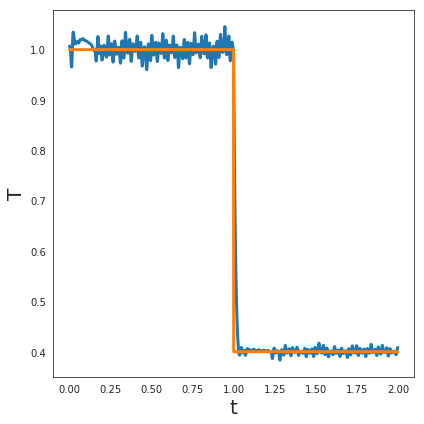

In [0]:
t = onp.arange(0, 2000) * dt
T = onp.array(T)
plt.plot(t, T, linewidth=3)
plt.plot(t, onp.array(T_schedule(t)), linewidth=3)
format_plot('t', 'T')
finalize_plot()

Now let's plot the Hamiltonian of the system. We see that it is invariant apart from changes tot he temperature, as expected.

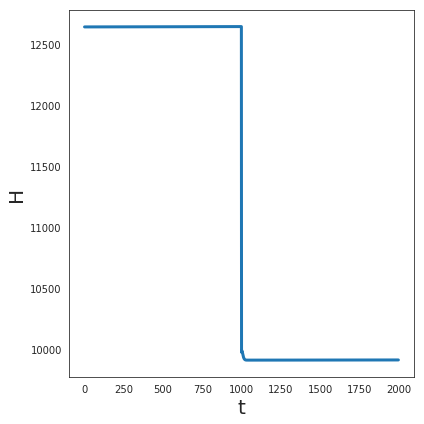

In [0]:
plt.plot(H, linewidth=3)
format_plot('t', 'H')
finalize_plot()

Now let's plot the system.

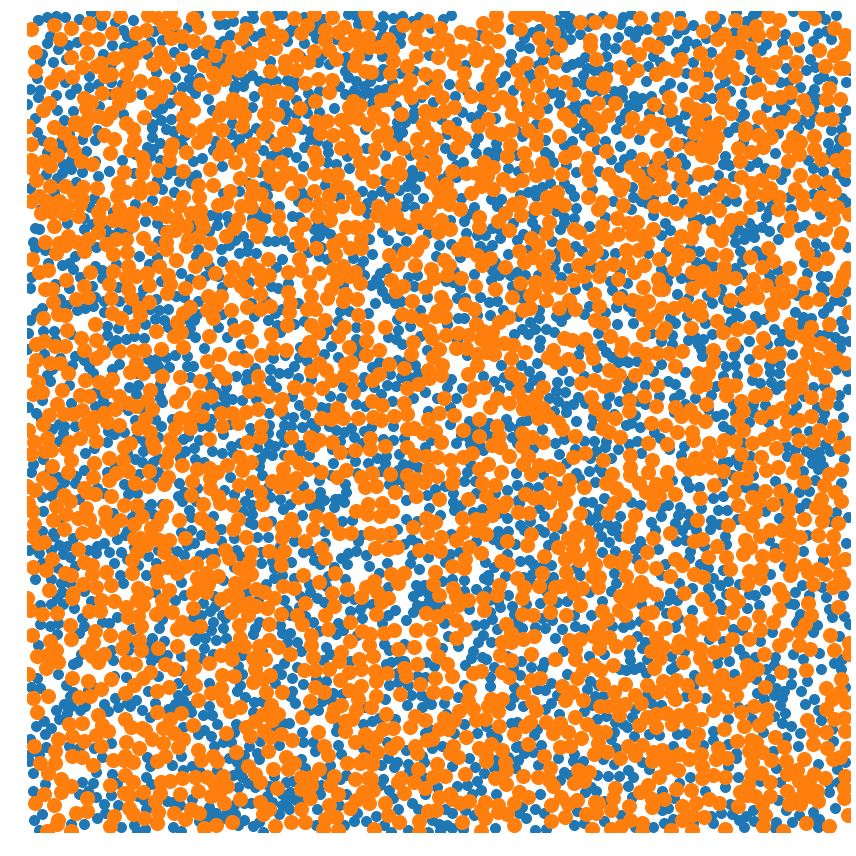

In [0]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Finally, let's plot the velocity distribution compared with its theoretical prediction.

In [0]:
V_flat = onp.reshape(onp.array(state.velocity), (-1,))
occ, bins = onp.histogram(V_flat, bins=100, normed=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


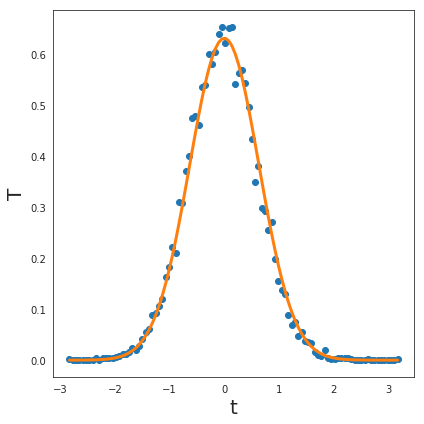

In [0]:
T_cur = T_schedule(20.0)
plt.plot(bins[:-1], occ, 'o')
plt.plot(
    bins[:-1], 
    1.0 / np.sqrt(2 * np.pi * T_cur) * onp.exp(-1/(2 * T_cur) * bins[:-1] ** 2), 
    linewidth=3)
format_plot('t', 'T')
finalize_plot()